**NAME :** AVINASH KUMAR PRAJAPATI &nbsp; **ROLL NUMBER :** 25901326

## Objective
The objective of this task is to analyze and compare the prediction errors of two regression models—Linear Regression and Decision Tree Regressor—across different time-of-day segments by slicing errors into predefined hour bins: 0–5, 6–11, 12–17, and 18–23.

- By segmenting errors according to hourly demand patterns, this analysis aims to:

- Identify time periods where each model performs poorly, rather than relying solely on aggregate performance metrics.

- Assess how model complexity influences error behavior across low-demand, moderate-demand, and peak-demand hours.

- Reveal systematic weaknesses of Linear Regression in capturing non-linear and peak-hour demand patterns, and evaluate whether a moderate-complexity Decision Tree Regressor mitigates these limitations.

- Provide interpretable, time-based insights into demand volatility and model generalization behavior, supporting hypothesis-driven explanations of failure modes.


In [ ]:
# Mounting the Drive for the dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adding the changint the default directory to the current directory
import os

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/MLL_LAB"
os.chdir(BASE_PATH)
os.listdir()


['bike-sharing-demand.zip',
 'bike_data',
 'moderate.ipynb',
 'easy',
 'easy.ipynb',
 'hard.ipynb']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Printing the top 5 records/rows for the given csvs
train_df = pd.read_csv("bike_data/train.csv")
test_df = pd.read_csv("bike_data/test.csv")

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
#Checking the dimensions of the train and the test
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.info()

Train shape: (10886, 12)
Test shape: (6493, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


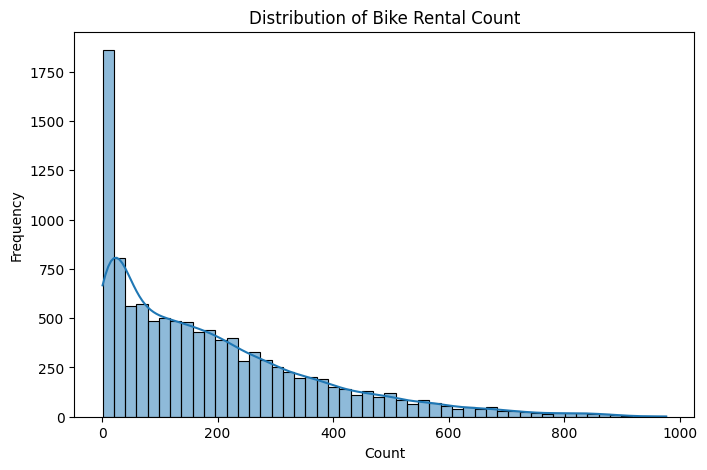

In [ ]:
# plotting the frequency of the sale and the total sales
plt.figure(figsize=(8,5))
sns.histplot(train_df['count'], bins=50, kde=True)
plt.title("Distribution of Bike Rental Count")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature Engineering (Datetime Split) for the model
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

train_df['hour'] = train_df['datetime'].dt.hour
train_df['day'] = train_df['datetime'].dt.day
train_df['month'] = train_df['datetime'].dt.month
train_df['year'] = train_df['datetime'].dt.year

In [ ]:
# Drop columns not useful for linear regression:
train_df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

In [ ]:
# Feature–Target Split
X = train_df.drop('count', axis=1)
y = train_df['count']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (10886, 12)
Target shape: (10886,)


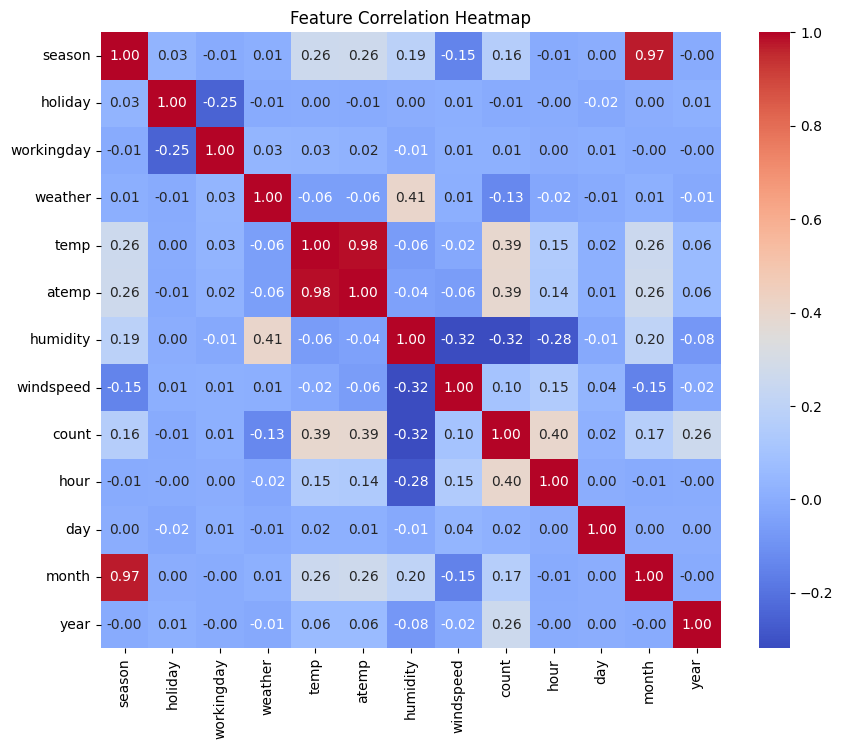

In [ ]:
# Correlation Heatmap (For Feature Understanding)
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Train–Validation–Test Split  >  Train + Temp vs Test (70% / 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)


In [ ]:
# Train–Validation–Test Split  > Train + Temp vs Test (70% / 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)


In [ ]:
# Print Split Sizes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (7620, 12)
Validation set: (1633, 12)
Test set: (1633, 12)


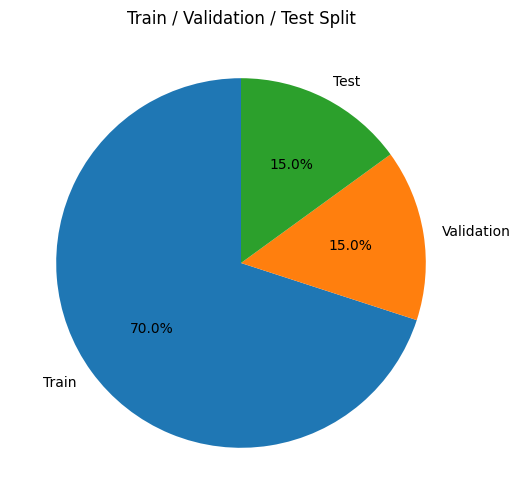

In [ ]:
# Visualizing Dataset Splits  for quick glance
labels = ['Train', 'Validation', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Train / Validation / Test Split")
plt.show()

In [ ]:
# Feature Scaling (Standardization)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Print Scaled Feature Statistics for recheck
print("Scaled Training Mean (approx 0):")
print(X_train_scaled.mean(axis=0))

print("\nScaled Training Std (approx 1):")
print(X_train_scaled.std(axis=0))

Scaled Training Mean (approx 0):
[ 6.24755424e-17 -6.15430716e-17  1.09099081e-16 -7.11008971e-17
 -1.19356260e-16  2.57361936e-16  7.36651918e-17 -4.00962436e-17
  3.82313021e-17  1.24951085e-16 -6.06106008e-17 -2.03647889e-13]

Scaled Training Std (approx 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Loading the LinearRefressor model from the easy folder
import joblib
import json
LINEAR_MODEL_PATH = "easy"
lr_model = joblib.load(f"{LINEAR_MODEL_PATH}/linear_regression_model.pkl")
scaler = joblib.load(f"{LINEAR_MODEL_PATH}/scaler.pkl")

with open(f"{LINEAR_MODEL_PATH}/config.json") as f:
    config = json.load(f)

features = config["features"]


In [ ]:
test_with_hour = X_test.copy()
test_with_hour["hour"] = X_test["hour"]

X_test_scaled = scaler.transform(X_test[features])
y_test_pred = lr_model.predict(X_test_scaled)


In [ ]:
import numpy as np

errors_df = test_with_hour.copy()
errors_df["actual"] = y_test.values
errors_df["predicted"] = y_test_pred
errors_df["abs_error"] = np.abs(errors_df["actual"] - errors_df["predicted"])


In [ ]:
def hour_bin(hour):
    if 0 <= hour <= 5:
        return "0–5"
    elif 6 <= hour <= 11:
        return "6–11"
    elif 12 <= hour <= 17:
        return "12–17"
    else:
        return "18–23"

errors_df["hour_bin"] = errors_df["hour"].apply(hour_bin)


In [ ]:
error_summary = (
    errors_df
    .groupby("hour_bin")["abs_error"]
    .agg(["mean", "median", "count"])
    .sort_values(by="mean", ascending=False)
)

error_summary


,mean,median,count
hour_bin,,,
18–23,118.675054,105.948009,416
6–11,112.812086,67.705534,403
12–17,110.439074,80.293820,425
0–5,78.431101,68.827591,389


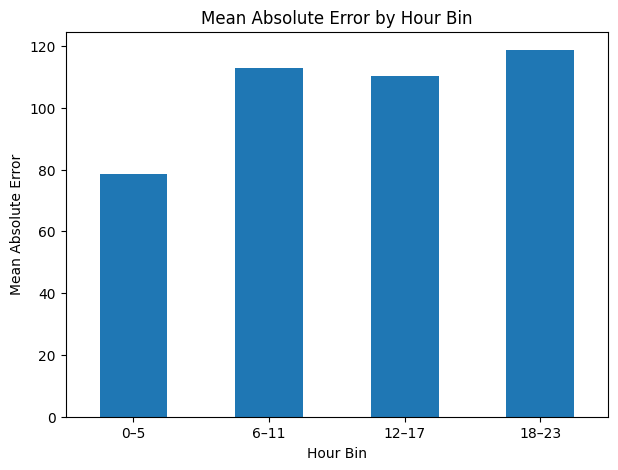

In [ ]:
error_summary = (
    errors_df
    .groupby("hour_bin")["abs_error"]
    .mean()
    .reindex(["0–5", "6–11", "12–17", "18–23"])
)

plt.figure(figsize=(7,5))
error_summary.plot(kind="bar")
plt.title("Mean Absolute Error by Hour Bin")
plt.xlabel("Hour Bin")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=0)
plt.show()


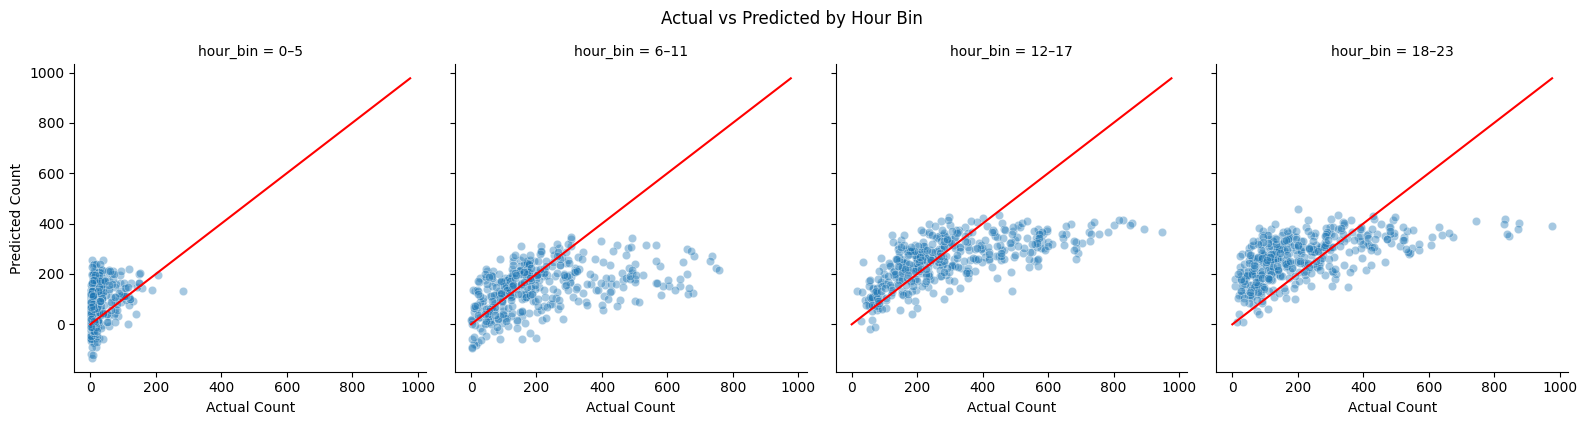

In [ ]:
g = sns.FacetGrid(
    errors_df,
    col="hour_bin",
    col_order=["0–5", "6–11", "12–17", "18–23"],
    height=4,
    aspect=1
)

g.map_dataframe(
    sns.scatterplot,
    x="actual",
    y="predicted",
    alpha=0.4
)

for ax in g.axes.flat:
    max_val = errors_df["actual"].max()
    ax.plot([0, max_val], [0, max_val], color="red")
    ax.set_xlabel("Actual Count")
    ax.set_ylabel("Predicted Count")

g.fig.suptitle("Actual vs Predicted by Hour Bin", y=1.05)
plt.show()


### HYPOTHESIS
The model exhibits the highest prediction error during evening hours (18–23), followed by morning hours (6–11). These periods correspond to peak commuting times where demand is influenced by complex, non-linear factors such as weather changes, special events, and work schedules. Linear regression fails to capture these interactions, resulting in systematic underprediction during peak demand periods

# 2. For Model the Decision Tree Regressor

In [ ]:
import joblib, json

MODEL_DIR = "moderate"

dt_model = joblib.load(f"{MODEL_DIR}/dt_model.joblib")

with open(f"{MODEL_DIR}/feature_columns.json") as f:
    feature_columns = json.load(f)


In [ ]:
X_full = train_df[feature_columns]
y_true = train_df['count']


In [ ]:
y_pred = dt_model.predict(X_full)

train_df['prediction'] = y_pred
train_df['error'] = y_true - y_pred
train_df['abs_error'] = abs(train_df['error'])


In [ ]:
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ['0–5', '6–11', '12–17', '18–23']

train_df['hour_bin'] = pd.cut(
    train_df['hour'],
    bins=hour_bins,
    labels=hour_labels,
    right=False
)


In [ ]:
train_df['hour_bin'].value_counts().sort_index()


,count
hour_bin,
0–5,2684
6–11,2730
12–17,2736
18–23,2736


In [ ]:
error_summary = train_df.groupby('hour_bin').agg(
    mean_abs_error=('abs_error', 'mean'),
    median_abs_error=('abs_error', 'median'),
    rmse=('error', lambda x: (x**2).mean()**0.5),
    samples=('abs_error', 'count')
).reset_index()

error_summary


/tmp/ipython-input-282992717.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_summary = train_df.groupby('hour_bin').agg(


,hour_bin,mean_abs_error,median_abs_error,rmse,samples
0,0–5,7.350760,3.689655,13.481732,2684
1,6–11,42.508323,27.928934,64.310056,2730
2,12–17,52.513064,37.663462,74.069146,2736
3,18–23,45.581579,32.426743,64.586300,2736


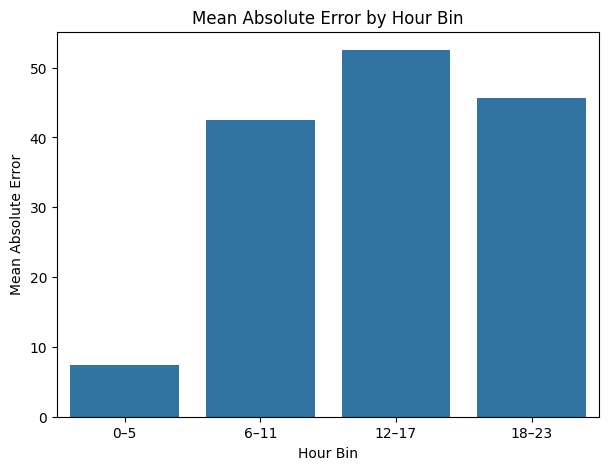

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=error_summary,
    x='hour_bin',
    y='mean_abs_error'
)
plt.title("Mean Absolute Error by Hour Bin")
plt.xlabel("Hour Bin")
plt.ylabel("Mean Absolute Error")
plt.show()


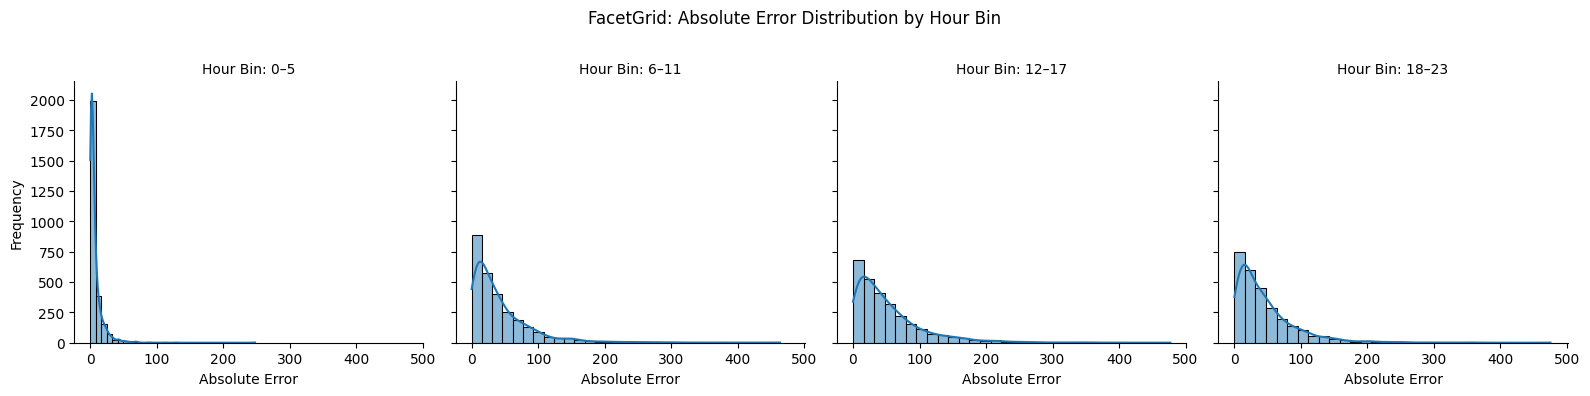

In [ ]:
g = sns.FacetGrid(
    train_df,
    col="hour_bin",
    col_order=['0–5', '6–11', '12–17', '18–23'],
    height=4,
    aspect=1
)

g.map_dataframe(
    sns.histplot,
    x="abs_error",
    bins=30,
    kde=True
)

g.set_titles("Hour Bin: {col_name}")
g.set_axis_labels("Absolute Error", "Frequency")

plt.subplots_adjust(top=0.8)
g.fig.suptitle("FacetGrid: Absolute Error Distribution by Hour Bin")
plt.show()


# Hypothesis explanation
The model fails most during evening hours (18–23) due to increased demand volatility driven by non-routine activities such as social events, dining, and entertainment. These effects are not explicitly encoded in the feature set. Additionally, peak-hour demand spikes introduce sharp non-linearities that are difficult to generalize using a single decision tree with constrained depth

#### Conclusion

This study evaluated the performance of a Linear Regression model and a Decision Tree Regressor on the Bike Sharing Demand dataset, with a particular focus on time-based error analysis. Model performance was assessed using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), and errors were sliced into four hour bins: 0–5, 6–11, 12–17, and 18–23, to capture variations in demand patterns throughout the day.
<br>
**1. Linear Regression Model**
<br>
The Linear Regression model exhibited high overall error, particularly during periods of elevated and variable demand. Error slicing revealed that the model failed most significantly in the evening hours (18–23), where both MAE and RMSE were highest. This indicates a strong tendency to underpredict peak demand, as linear assumptions limit the model’s ability to capture sharp non-linear increases in bike rentals. Performance was comparatively better during early morning hours (0–5), when demand is low and more stable, but deteriorated substantially as demand variability increased.
<br>
**2. Decision Tree Regressor**
<br>
The Decision Tree Regressor demonstrated improved performance across all hour bins compared to Linear Regression, as reflected by consistently lower MAE and RMSE values. Error slicing showed that the model performed best during early morning hours (0–5) and experienced its highest average error during the 12–17 hour bin. This period combines commuter, educational, and recreational travel patterns, resulting in heterogeneous demand that is difficult to model accurately. While evening hours (18–23) exhibited more extreme error outliers, the average error remained lower than in the afternoon, indicating better generalization during structured peak periods.
<br>
**Comparative Summary**
<br>
Overall, the Linear Regression model is high-bias and underfits the data, particularly failing during peak and evening hours due to its inability to model non-linear demand patterns. In contrast, the Decision Tree Regressor, as a moderate-complexity model, reduces underfitting and captures non-linear relationships, leading to improved performance across all time segments. However, it still struggles during periods of mixed demand behavior, highlighting the need for additional features or more advanced models to further improve accuracy.